In [1]:
from casadi import *
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.interpolate as ip

from path_module import *
from opt_module import *


In [2]:
T = 4 # Time horizon
ns = 20 # number of control intervals

# Dimensions
nx = 4
nu = 2
nxu = nx + nu
npar = 2
n_obs = 10

Skid-steering kinematic model augmented with acceleration
$$
\begin{pmatrix}
\dot{x} \\ \dot{y} \\ \dot{\theta} \\ \dot{v}_x
\end{pmatrix} = \begin{pmatrix}
  v_x \cos\theta + x_{ICR} \omega \sin\theta \\ v_x \sin\theta -x_{ICR} \omega \cos\theta \\ \omega \\ a_x
\end{pmatrix}, \ \mathbf{x}=\begin{pmatrix} x \\ y \\ \theta \\ v_x\end{pmatrix}, \ \mathbf{u}=\begin{pmatrix} a_x \\ \omega \end{pmatrix}
$$

In [3]:
# ode, dynamic model
x  = SX.sym('x', nx)  # state
u  = SX.sym('u', nu)  # control
xICR = SX.sym('xICR',1) # skid-steering parameter

xdot = vertcat(x[3]*cos(x[2]) + xICR * u[1]*sin(x[2]), \
              x[3]*sin(x[2]) - xICR * u[1]*cos(x[2]), \
              u[1], \
              u[0]) # u[0]->acc u[1]->steer
f = Function('f', [x,u,xICR], [xdot])

DT = MX.sym('DT')
X0 = MX.sym('X0',nx)
U  = MX.sym('U',nu)
# define ode and objective function
X_ICR = MX.sym('X_ICR')
Width = MX.sym('Width')
M_param = vertcat(X_ICR,Width)
disc = discretization("rk4",nx,f)
XPred = disc.rk4(X0,U,M_param[0],DT)

F = Function('F', [X0, U, M_param, DT], [XPred]).expand()    #, Y_LT, Y_RT

NV = nx*(ns+1) + nu*ns
V = MX.sym("V", NV)
Vd = reshape(V[:-nx],nxu,ns) # matrix nxu * ns
Xk = Vd[:nx,:]
Uk = Vd[nx:,:] # matrix nu * ns
Xn= F.map(ns, 'openmp',True)(Xk, Uk, M_param, DT)


NameError: name 'discretization' is not defined

Reference path for following
$$
y_{ct} = c_3 (x+x_{offset})^3 + c_2 (x+x_{offset})^2 + c_1 (x+x_{offset}) + c_0
$$

In [4]:
# project x coord into reference curve
x_offset = SX.sym('x_offset')
ct_coeff = SX.sym('ct_coeff',4)

y_ct = ct_coeff[3]*pow(x[0]+x_offset,3) + ct_coeff[2]*pow(x[0]+x_offset,2) + ct_coeff[1]*pow(x[0]+x_offset,1) + ct_coeff[0]*pow(x[0]+x_offset,0)


Left and right boundaries
$$
\begin{aligned}
\mathrm{Left:} \ y(k) + \rho_{ego} \leq y_{lt}(k) \\
\mathrm{Right:} \ y(k) - \rho_{ego} \geq y_{rt}(k)
\end{aligned}
$$

In [5]:
# project x coord into left and right curve
x_offset_l = SX.sym('x_offset_l')
x_offset_r = SX.sym('x_offset_r')
rt_coeff = SX.sym('rt_coeff',4)
lt_coeff = SX.sym('lt_coeff',4)
width = SX.sym('width')

y_lt = lt_coeff[3]*pow(x[0]+x_offset_l,3) + lt_coeff[2]*pow(x[0]+x_offset_l,2) + lt_coeff[1]*pow(x[0]+x_offset_l,1) + lt_coeff[0]*pow(x[0]+x_offset_l,0)
y_rt = rt_coeff[3]*pow(x[0]+x_offset_r,3) + rt_coeff[2]*pow(x[0]+x_offset_r,2) + rt_coeff[1]*pow(x[0]+x_offset_r,1) + rt_coeff[0]*pow(x[0]+x_offset_r,0)
g_1 = x[1] + width - y_lt
g_2 = y_rt + width - x[1]

Obstacle avoidance with ellipse
$$
\frac{((x-x_{obs})\cos\theta + (y-y_{obs})\sin\theta)^2}{a^2} + \frac{((x-x_{obs})\sin\theta - (y-y_{obs})\cos\theta)^2}{b^2} > 1
$$

In [6]:
# obstacle parameters
obs = SX.sym('obs',5) # x, y, r1, r2, theta
obs_dist = pow((x[0]-obs[0])*cos(obs[4]) + (x[1]-obs[1])*sin(obs[4]),2)/pow(obs[2],2) + pow((x[0]-obs[0])*sin(obs[4]) - (x[1]-obs[1])*cos(obs[4]),2)/pow(obs[3],2)
g_3 = 1 - obs_dist

Cost function
$$
J = \mathrm{path\ follow} + \mathrm{terminal} + \mathrm{penalty}
$$

Path following term
$$
w_{ct}(y(k)-y_{ct}(k))^2 + w_v(v_x - v_{ref})^2 + w_u\mathbf{u}^2
$$
Terminal term
$$
w_{tf}(\mathbf{x}(N)-\mathbf{x}_{tf})^2
$$

In [7]:
v_ref = SX.sym('vref')
x_tf = SX.sym('xtf',nx)
# weighting parameters
w_x = SX.sym('w_x',nx)
w_u = SX.sym('w_u',nu)
w_y = SX.sym('w_y')
w_v = SX.sym('w_v')
w_tf = SX.sym('w_tf',nx)

# reference following
follow_term = w_y*pow((x[1] - y_ct),2) + w_v*pow((x[3] - v_ref),2) + mtimes(u.T,mtimes(diag(w_u),u))
terminal_term = mtimes((x-x_tf).T,mtimes(diag(w_tf),(x-x_tf)))

obj_follow = Function('obj_follow', [x,u, v_ref, ct_coeff, x_offset, vertcat(w_y,w_v,w_u)],[follow_term])
obj_terminal = Function('obj_terminal',[x,x_tf,w_tf],[terminal_term])

Soft contraint $g(x,u) \leq 0$ in exponential equation
$$
w_{pnt}\exp(g(x,u))
$$

In [8]:
w_obs = SX.sym('w_obs')
w_y_l = SX.sym('w_y_l')
w_y_r = SX.sym('w_y_r')

left_side_term = w_y_l*exp(g_1) # penalty term for left and right distance
right_side_term = w_y_r*exp(g_2)

obs_term = w_obs*exp(g_3) # penalty term for obstacle avoidance

obj_side_l = Function('obj_side_l',[x,lt_coeff,w_y_l,x_offset_l,width],[left_side_term])
obj_side_r = Function('obj_side_r',[x,rt_coeff,w_y_r,x_offset_r,width],[right_side_term])
obj_obs = Function('obj_obs',[x,obs,w_obs],[obs_term])


In [9]:
Q = 0

XF = MX.sym('XF',nx)
V_ref = MX.sym('V_ref')
CT_coeff = MX.sym("CT",4)
X_offset_c = MX.sym('X_offset_c')
W_ref = MX.sym('W_ref',4)
Q += obj_follow(XF,U,V_ref,CT_coeff,X_offset_c,W_ref)

LT_coeff = MX.sym("LT",4)
W_lt = MX.sym('W_lt')
X_offset_l = MX.sym('X_offset_l')
RT_coeff = MX.sym("RT",4)
W_rt = MX.sym('W_rt')
X_offset_r = MX.sym('X_offset_r')
Q += obj_side_l(XF,LT_coeff,W_lt,X_offset_l,Width) + obj_side_r(XF,RT_coeff,W_rt,X_offset_r,Width) 

Obs_ml = MX.sym("Obs_ml",5,n_obs)
W_obs = MX.sym('W_obs',n_obs)
obs_term_ml = obj_obs.map(n_obs, 'openmp',True)(XF,Obs_ml,W_obs)
Q_obs = sum2(obs_term_ml)
Q += Q_obs

Weights = vertcat(W_ref,W_lt,W_rt,W_obs)
X_offset = veccat(X_offset_c,X_offset_l,X_offset_r)
Path_coeff = vertcat(CT_coeff,LT_coeff,RT_coeff)

QF = Function('QF', [XF, U, Width, V_ref, Path_coeff,X_offset,Obs_ml,Weights], [Q]).expand()    #, Y_LT, Y_RT
Qn= QF.map(ns, 'openmp',True)(Xn, Uk, Width, V_ref, Path_coeff, X_offset, Obs_ml, Weights)

X_tf = MX.sym('X_tf',nx)
W_tf = MX.sym('W_tf',nx)
Q_terminal = obj_terminal(V[-nx:],X_tf,W_tf)

J = sum2(Qn) + Q_terminal
W_cost = vertcat(Weights,W_tf)


Continuity constraints: $$ \mathbf{x}_p - \mathbf{x}_{k+1} = 0 $$

In [10]:
# continuity constraints
gaps = Xn[:,:]-horzcat(Xk[:,1:],V[-nx:])

In [11]:
nlp = []
nlp = {'x':V,  'p': veccat(M_param, DT, V_ref, Path_coeff, X_offset, X_tf, Obs_ml, W_cost),'f':J,'g': vec(gaps)} #,vec(g_lt),vec(g_rt)

opts = {}
ipopt_opts = {}
ipopt_opts["tol"] = 1e-5;
ipopt_opts["max_iter"] = 100;
ipopt_opts["print_level"] = 5;
ipopt_opts["sb"] = "yes";
ipopt_opts["acceptable_tol"] = 1e-5;
ipopt_opts["acceptable_iter"] = 0;
ipopt_opts["linear_solver"] = 'ma27';
# ipopt_opts["hessian_approximation"] = "limited-memory";
ipopt_opts["warm_start_init_point"] = "yes";
ipopt_opts["warm_start_bound_push"] = 1e-6;
ipopt_opts["warm_start_mult_bound_push"] = 1e-6;
opts["expand"] = False
opts["print_time"] = 0;
opts["ipopt"] = ipopt_opts

compiler = "gcc"    # Linux
flags = ["-O3"] # Linux/OSX

generate_c = True
# external c codegen
plugin_name = "nmpc_cartesian_dyn_whizzy"
if generate_c:
    solver = nlpsol('solver', 'ipopt', nlp,opts);
    solver.generate_dependencies(plugin_name+".c")

    import subprocess
    cmd_args = ["mv",plugin_name+".c","../gen_c"]
    subprocess.run(cmd_args)
    cmd_args = [compiler,"-fPIC","-shared"]+flags+["../gen_c/"+plugin_name+".c","-o","../gen_c/"+plugin_name+".so"]
    subprocess.run(cmd_args)

solver = nlpsol("solver", "ipopt", "../gen_c/"+plugin_name+".so",opts)

In [12]:
x_ref = np.array([0.050,0.063,0.081,0.104,0.131,0.162,0.197,0.237,0.281,0.329,0.382,0.438,0.498,0.562,0.630,0.701,0.777,0.856,0.938,1.020,1.102,1.184,1.265,1.345,1.426,1.506,1.587,1.667,1.747,1.827])
y_ref = np.array([0.037,0.044,0.052,0.063,0.076,0.092,0.110,0.131,0.154,0.181,0.210,0.242,0.278,0.317,0.359,0.404,0.453,0.506,0.562,0.619,0.677,0.735,0.794,0.853,0.912,0.971,1.031,1.091,1.150,1.210])

poly_path = ParametricCurve("Polynomial")
ct_coeff_val = poly_path.curve_fit(x_ref,y_ref)


In [13]:

# jit codegen
# jit_options = {"flags": flags, "verbose": True, "compiler": compiler}
# options = {"jit": True, "compiler": "shell", "jit_options": jit_options, "ipopt": ipopt_opts}
# solver = nlpsol("solver", "ipopt", nlp, options)
    # argument for nlp
w0, lbw, ubw, lbg, ubg, params = [],  [], [], [], [], []
ini_heading = 0
y_i = 0
v_ini = 0.0
# initial value boundaries
lbw += [0, y_i, ini_heading, v_ini]
ubw += [0, y_i, ini_heading, v_ini]
w0 += [0, y_i, ini_heading, v_ini]

for k in range(ns):
    # box constraints for controls
    lbw += [ -1.0, -1.57]
    ubw += [1.0, 1.57]
    # box constraints for states
    lbw += [-inf, -inf, -inf, 0]
    ubw += [inf, inf, inf, 1.0]
    # continuity constraints
    lbg += [0, 0, 0, 0]
    ubg += [0, 0, 0, 0]
    
    w0 += [0, 0, 0, 0, 0, 0]

xICR_val = 0.00248
width_val = 0.5
v_ref_val = 0.5
M_param_val = [xICR_val,width_val]

dt_val = T/ns
# xe, ye, theta_e, v_e, acc, omega
w_ref_val = [40,20,1,0] # add weighting params
w_left_val = 10
w_right_val = 10
w_path_val = [10,40,50,5,w_left_val,w_right_val]
w_obs_val = [0,10,10,10,10,10,10,10,10,10]
p1 = Point(0.5, 0.23)
p2 = Point(0.75, 0.4)
inflation_rate = 0.1
ell = Ellipse(p1,p2)
center, a, b, theta = ell.approximate_line_with_ellipse(inflation_rate)
theta = theta
# x_obs, y_obs, r1, r2, theta_obs
obs_val = [center.x, center.y ,2*a, 2*b, theta,
           125, 20 ,0.2, 0.2, -pi/4,
           100, 70 ,0.4, 0.2, -pi/4,
           100, 70 ,0.4, 0.2, -pi/4,
           100, 70 ,0.4, 0.2, -pi/4,
           100, 70 ,0.4, 0.2, -pi/4,
           100, 70 ,0.4, 0.2, -pi/4,
           100, 70 ,0.4, 0.2, -pi/4,
           100, 70 ,0.4, 0.2, -pi/4,
           100, 70 ,0.4, 0.2, -pi/4] # [1, 0.7 ,0.4, 0.2, -pi/4]
lt_val = [10, 0, 0, 0] #[0.5,0.2,0,0]
rt_val = [-10, 0, 0, 0] #[-0.5,0.1,0,0]
x_tf_val = [x_ref[-1],y_ref[-1],0,0.5]
w_tf_val = [30,30,0,10]
x_offset_c_val = 0
x_offset_l_val = 0
x_offset_r_val = 0
x_offset_val = [x_offset_c_val,x_offset_l_val,x_offset_r_val]
# print(np.zeros([30,2]))
# P_M, V_ref, CT_coeff, X_offset,X_offset_l,X_offset_r, X_tf, W_ref,W_lt,W_rt, W_tf, Obs_ml,W_obs,LT_coeff,RT_coeff,Width)

params += M_param_val
params.append(dt_val)
params.append(v_ref_val)
params += ct_coeff_val.tolist()
params += lt_val
params += rt_val
params += x_offset_val
params += x_tf_val
params += obs_val
params += w_path_val
params += w_obs_val
params += w_tf_val

This is Ipopt version 3.14.16, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:      352
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      406

Total number of variables............................:      120
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:       80
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4682957e+02 9.90e-07 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   

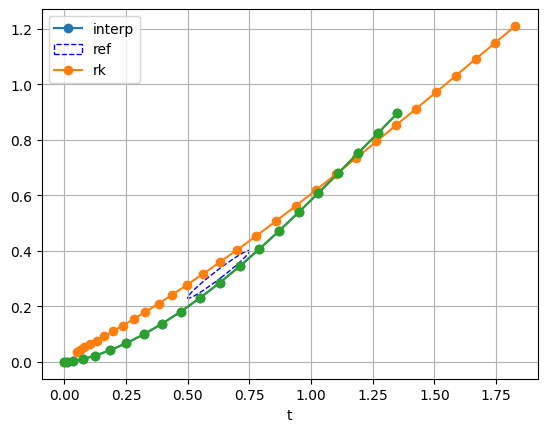

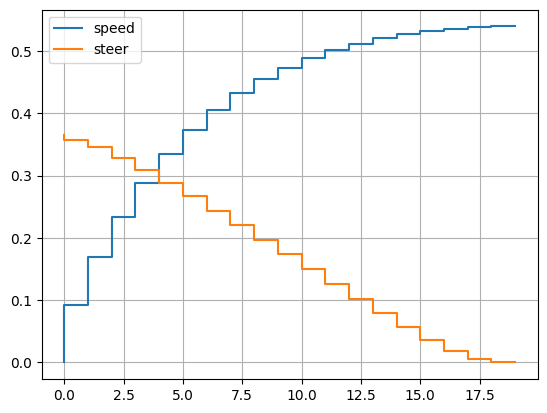

In [14]:

sol = solver(x0=w0, p=params, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
w_opt = []
print(sol['x'])
w_opt = sol['x']

# Plot the solution
x1_opt = w_opt[0::nxu]
x2_opt = w_opt[1::nxu]
x3_opt = w_opt[2::nxu]
x4_opt = w_opt[3::nxu]

u1_opt = w_opt[4::nxu]
u2_opt = w_opt[5::nxu]

tgrid = [T/ns*k for k in range(ns+1)]

fig, ax = plt.subplots()

plt.figure(1)
# plt.clf()
# plt.plot(ref_traj[0::nxu], ref_traj[1::nxu], '--')
plt.plot(x1_opt, x2_opt, '-o')
# plt.plot(u1_opt, x2_opt1, '-o')
# Ellipse parameters
ellipse = plt.matplotlib.patches.Ellipse(
    (center.x, center.y), width=2*a, height=2*b, angle=np.degrees(theta),
    edgecolor='blue', facecolor='none', linestyle='--', label='Approximating Ellipse'
)

# Add the ellipse to the plot
ax.add_patch(ellipse)

plt.plot(x_ref, y_ref, 'o-')

plt.plot(x1_opt, x2_opt, '-o')

plt.xlabel('t')
plt.legend(['interp','ref','rk'])
plt.grid()
plt.show()
plt.figure(2)
plt.step(range(ns),x4_opt[:-1])
plt.step(range(ns),u2_opt)
plt.legend(['speed','steer'])

plt.grid()
plt.show()
